In [109]:
# usual packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import h5py

import sys
#sys.modules.pop('CLASS_BABY')
#sys.modules.pop('CLASS_SAMPLE')


from CLASS_BABY import *
from CLASS_SAMPLE import *

import scipy.stats as ss

#bigger fonts
import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rcParams.update({'font.size': 20})

# machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler#,Imputer

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [257]:
def median_in_bins_err(x,y,x1,x2,nbins,p1=0.25,p2=0.75):
    medians_x = np.zeros(nbins)
    medians_y = np.zeros(nbins)
    err_y_low = np.zeros(nbins)
    err_y_high = np.zeros(nbins)
    x = np.array(x)
    y = np.array(y)
    width = (float(x2)-float(x1))/nbins
    for i in range(int(nbins)):
        x_low = x1 + i*width
        x_high = x1+ (i+1)*width
        #print x_low, x_high
        sel = np.where((x>x_low)&(x<x_high))
        temp_ord = np.copy(y[sel])
        temp_ord = np.sort(temp_ord)
        medians_y[i] = temp_ord[int(len(temp_ord)*0.50 + 0.5)]
        err_y_low[i]  = np.abs(temp_ord[int(len(temp_ord)*p1 + 0.5)]-medians_y[i])
        err_y_high[i]  = np.abs(temp_ord[int(len(temp_ord)*p2 + 0.5)]-medians_y[i])
        #err_y[i] = [err_y_low,err_y_high]
        medians_x[i] = np.median(x[sel])
    return np.array(medians_x),np.array(medians_y),err_y_low,err_y_high

In [190]:
#pr,spo2,med_pr,med_spo2 = np.loadtxt('../TOST_data/total_datapoints.txt',unpack=True)
pr, spo2, pi, med_pr, med_spo2, med_pi = np.loadtxt('../TOST_data/total_datapoints_pi.txt',unpack=True)

In [191]:
#good_val = np.where(((~np.isnan(pr))&(~np.isnan(spo2))&(~np.isnan(med_pr))&(~np.isnan(med_spo2))))
#good_val = np.where(((pr>10.)&(spo2>10)&(med_pr>10.)&(med_spo2>10)))
good_val = np.where(((pr>10.)&(spo2>10)&(med_pr>10.)&(med_spo2>10)&(pi>0.000001)&(pi<100)))

In [193]:
len(med_pr[good_val])

928494

In [204]:
INPUT = np.array([pr[good_val],med_pr[good_val],med_spo2[good_val],pi[good_val],med_pi[good_val]],dtype=float).T

In [205]:
INPUT.shape

(928494, 5)

In [206]:
INPUT[0]

array([117. , 115. ,  95. ,   0.6,   0.7])

In [207]:
np.unique(np.isnan(INPUT))

array([False])

In [208]:
#np.where(np.isnan(INPUT))

In [209]:
OUTPUT = np.array(spo2[good_val],dtype=float)

In [210]:
OUTPUT.shape

(928494,)

In [211]:
OUTPUT

array([96., 96., 96., ..., 93., 94., 94.])

In [212]:
INPUT_NORM = INPUT

In [213]:
# NORMALIZATION
scaler = StandardScaler()
scaler.fit(INPUT)
INPUT_NORM = scaler.transform(INPUT)


In [216]:
# SPLIT TRAIN AND TEST
input_train,input_test, output_train, output_test = train_test_split(INPUT_NORM, OUTPUT, test_size=0.5)

In [217]:
print ("training sample size: ",len(input_train))
print ("test sample size: ",len(input_test))
print ("train + test (total sample) = ", len(input_train)+len(input_test))
print ("train / sample =", round(float(len(input_train))/float(len(INPUT_NORM)),1))
print ("test / sample =", round(float(len(input_test))/float(len(INPUT_NORM)),1))

training sample size:  464247
test sample size:  464247
train + test (total sample) =  928494
train / sample = 0.5
test / sample = 0.5


In [243]:
# DEFINE MODEL ARCHITECTURE
model = Sequential()
model.add(Dense(6,input_dim=5,activation='relu'))
#model.add(Dense(6,activation='relu'))
model.add(Dense(3,activation='relu'))
model.add(Dense(1,activation='linear'))

In [244]:
# CREATE MODEL 
model.compile(loss='mean_squared_error', # 'mean_absolute_error' 
              optimizer='adam',
              metrics=['accuracy'] ) 

In [251]:
# TRAIN THE MODEL

# stop training if after 10 iterations 
# the results has not improved
early_stopping = EarlyStopping(monitor='loss',
                               patience=10)

N_EPOCHS = 5000
BATCH_SIZE = 1000
VALIDATION_FRACTION = 0.33
hist = model.fit(input_train,
                 output_train,
                 epochs=N_EPOCHS,
                 shuffle=False,
                 batch_size=BATCH_SIZE,
                 validation_split=VALIDATION_FRACTION,
                 callbacks=[early_stopping])

Train on 311045 samples, validate on 153202 samples
Epoch 1/5000
311045/311045 [==============================] - 1s 2us/step - loss: 9.8345 - acc: 0.2234 - val_loss: 9.7415 - val_acc: 0.2170
Epoch 2/5000
311045/311045 [==============================] - 1s 2us/step - loss: 9.8158 - acc: 0.2202 - val_loss: 9.7407 - val_acc: 0.2173
Epoch 3/5000
311045/311045 [==============================] - 1s 2us/step - loss: 9.8150 - acc: 0.2198 - val_loss: 9.7401 - val_acc: 0.2181
Epoch 4/5000
311045/311045 [==============================] - 1s 2us/step - loss: 9.8146 - acc: 0.2197 - val_loss: 9.7397 - val_acc: 0.2190
Epoch 5/5000
311045/311045 [==============================] - 1s 2us/step - loss: 9.8143 - acc: 0.2197 - val_loss: 9.7394 - val_acc: 0.2198
Epoch 6/5000
311045/311045 [==============================] - 1s 2us/step - loss: 9.8142 - acc: 0.2197 - val_loss: 9.7394 - val_acc: 0.2208
Epoch 7/5000
311045/311045 [==============================] - 1s 2us/step - loss: 9.8142 - acc: 0.2198 - val

In [252]:
l,a = model.evaluate(input_test,output_test)#[0]
#l = model.evaluate(input_test,output_test)#[0]
#a=0
#a = model.evaluate(input_test,output_test)[1]
print('NUMBER OF INPUT VARIABLES = ',len(INPUT))
print('NUMBER OF EPOCHS = ',N_EPOCHS)
print('VALIDATION FRACTION = ',VALIDATION_FRACTION)
print('BATCH SIZE = ',BATCH_SIZE)
print('Model loss function =\t%.2f\nModel Accuracy =\t%.2f'%(l,a))

464247/464247 [==============================] - 8s 17us/step
NUMBER OF INPUT VARIABLES =  928494
NUMBER OF EPOCHS =  5000
VALIDATION FRACTION =  0.33
BATCH SIZE =  1000
Model loss function =	9.88
Model Accuracy =	0.22


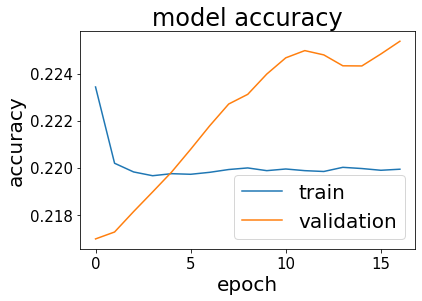

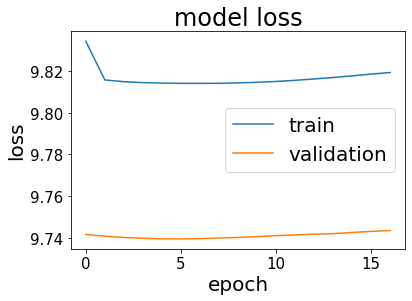

In [253]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [254]:
# prediction on the test sample
prediction = model.predict(input_test)

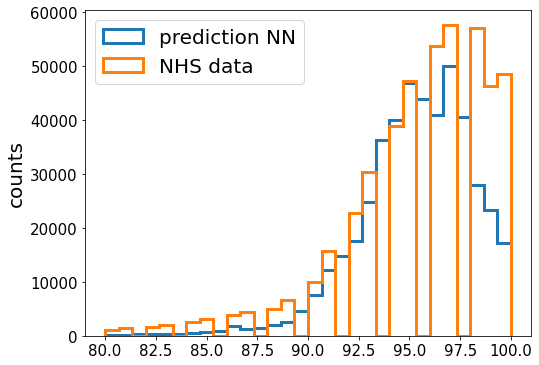

In [255]:
# distribution of prediction vs real data
plt.figure(figsize=(8,6))
plt.hist(prediction,bins=30,lw=3,histtype='step',label=r'prediction NN',range=(80,100)) # range=(0.,60.)
plt.hist(output_test,bins=30,lw=3,histtype='step',label=r'NHS data',range=(80,100))
#plt.xlabel('number of episodes of bradycardia (thr 120)',fontsize=20)
#plt.xlabel('ratio of time in bradycardia',fontsize=20)
plt.ylabel('counts',fontsize=20)
plt.legend(fontsize=20,loc=2)
plt.show()

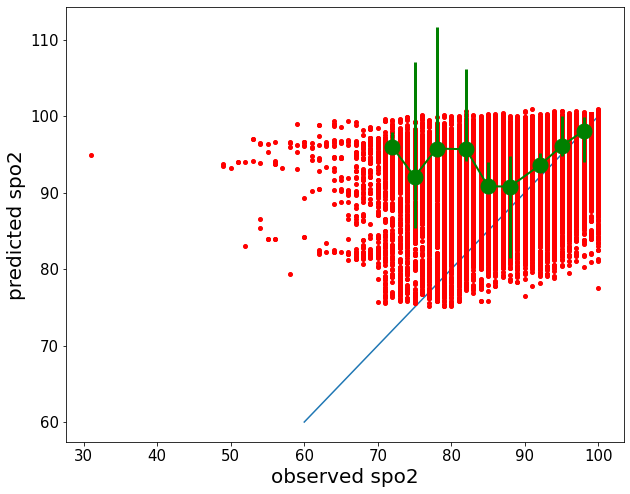

In [261]:
# plot of prediction vs real data
plt.figure(figsize=(10,8))
plt.plot([60.,100.],[60.,100.])
#plt.plot([0.,60.],[0.,60.],'k')
#plt.plot([0.,1.2],[0.,1.2],'k')

xx,yy,ey1,ey2 = median_in_bins_err(output_test,prediction,70,100,9)
plt.errorbar(xx,yy,yerr=[ey1,ey2],fmt=".",markersize=30,elinewidth=3,color='green',zorder=11,label='THR 100')
plt.plot(xx,yy,color="green",lw=2,zorder=12)


plt.plot(output_test,prediction,".r",markersize=8)
#plt.xlim(-0.5,20.)
#plt.ylim(-0.5,20.)
#plt.xlabel(r'number of brady-episodes observed',fontsize=20)
#plt.ylabel(r'number of brady-episodes predicted',fontsize=20)
plt.xlabel(r'observed spo2',fontsize=20)
plt.ylabel(r'predicted spo2',fontsize=20)
plt.show()

In [172]:
len(prediction)

496339

In [173]:
prediction

array([[91.45266],
       [96.08926],
       [91.52654],
       ...,
       [97.56516],
       [93.68043],
       [94.57732]], dtype=float32)